In [7]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


#Task 2: Image Data Collection and Processing


🧑 Showing facial expressions for: reine


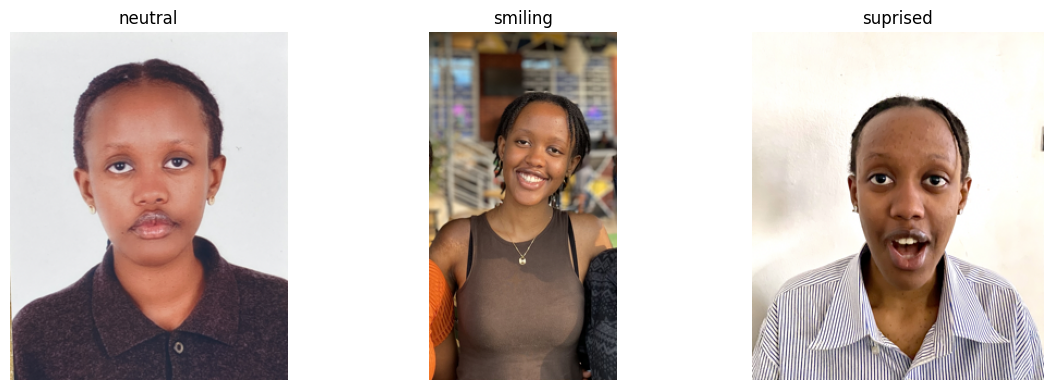


🧑 Showing facial expressions for: michael


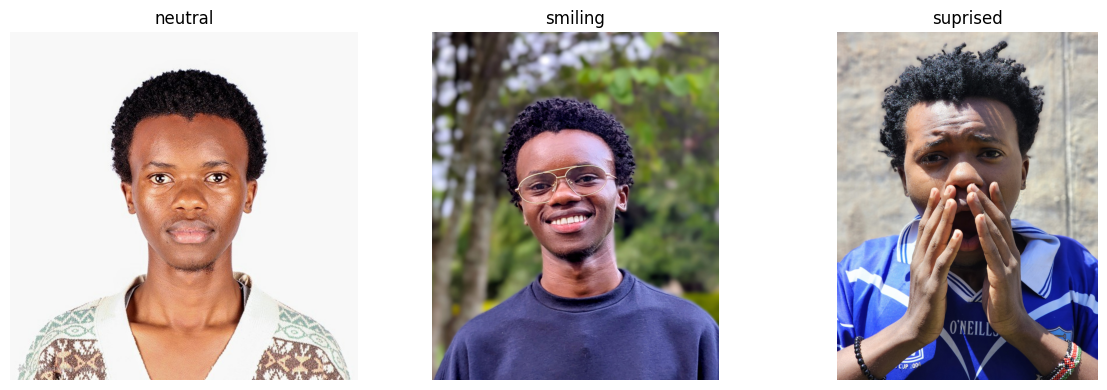


🧑 Showing facial expressions for: gustav


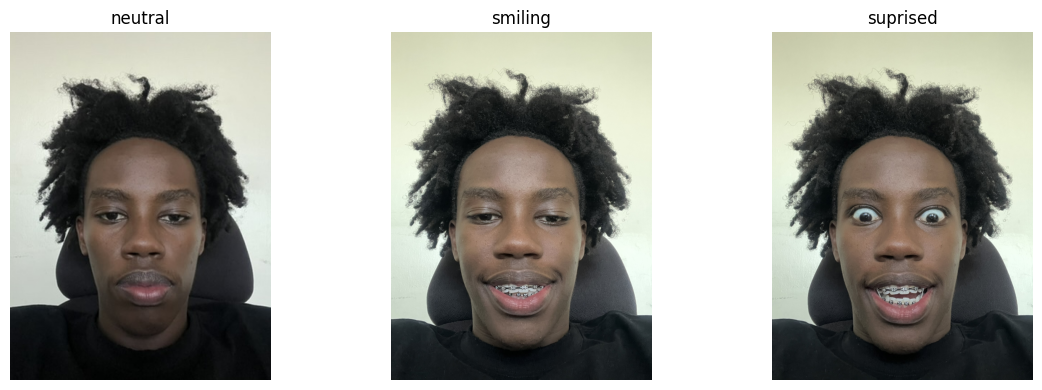

In [8]:
# Displaying images of group members
members = ['reine', 'michael', 'gustav']
expressions = ['neutral', 'smiling', 'suprised']

def display_group_images():
    for member in members:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        print(f"\n🧑 Showing facial expressions for: {member}")
        for i, expression in enumerate(expressions):
            filename = f"{member}_{expression}.jpeg"
            if os.path.exists(filename):
                img = cv2.imread(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axs[i].imshow(img)
                axs[i].set_title(f"{expression}", fontsize=12)
                axs[i].axis('off')
            else:
                axs[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
                axs[i].set_title(expression)
                axs[i].axis('off')
        plt.tight_layout()
        plt.show()

display_group_images()


In [9]:
# Augmentations function
def augment_image(image):
    # Resize to consistent size
    image = tf.image.resize(image, [224, 224])

    # Horizontal flip
    flipped = tf.image.flip_left_right(image)

    # Rotation (30 degrees)
    rotated = tf.image.rot90(image, k=1)

    # Grayscale
    grayscale = tf.image.rgb_to_grayscale(image)

    return [flipped, rotated, grayscale]


In [10]:
# saving the image
def save_image(tensor, path):
    array = tf.cast(tensor * 255.0, tf.uint8).numpy()
    if array.shape[-1] == 1:
        array = array.squeeze(-1)  # Grayscale to 2D
    img = Image.fromarray(array)
    img.save(path)


In [11]:
# Augment only the 12 specific images
def augment_and_save_tf(output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for member in members:
        for expression in expressions:
            filename = f"{member}_{expression}.jpeg"
            if os.path.exists(filename):
                img_path = filename

                # Load image
                image = tf.io.read_file(img_path)
                image = tf.image.decode_image(image, channels=3)
                image = tf.image.convert_image_dtype(image, tf.float32)

                # Apply augmentations
                augmented = augment_image(image)

                # Save augmented versions
                base_name = os.path.splitext(filename)[0]
                for i, aug in enumerate(augmented):
                    aug_filename = f"{base_name}_aug{i}.png"
                    save_path = os.path.join(output_dir, aug_filename)
                    save_image(aug, save_path)
                print(f"Augmented: {filename}")
            else:
                print(f"Not found: {filename}")


In [12]:
augment_and_save_tf("./augmented_images")

Augmented: reine_neutral.jpeg
Augmented: reine_smiling.jpeg
Augmented: reine_suprised.jpeg
Augmented: michael_neutral.jpeg
Augmented: michael_smiling.jpeg
Augmented: michael_suprised.jpeg
Augmented: gustav_neutral.jpeg
Augmented: gustav_smiling.jpeg
Augmented: gustav_suprised.jpeg


In [13]:
# Extracting features
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
root_dir = '.'
augmented_folder = 'augmented_images'

def load_and_preprocess_image(img_path):
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img)

    if img_array.ndim == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)
    elif img_array.shape[-1] == 1:
        img_array = np.repeat(img_array, 3, axis=-1)

    img_array = preprocess_input(img_array.astype(np.float32))
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
features = []
labels = []

# First process original images in root directory
for filename in os.listdir(root_dir):
    if filename.endswith('.jpeg'):
        img_path = os.path.join(root_dir, filename)
        try:
            img_tensor = load_and_preprocess_image(img_path)
            feature_vector = mobilenet.predict(img_tensor)[0]
            features.append(feature_vector)
            labels.append(filename)
            print(f"✅ Extracted features from: {filename}")
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
✅ Extracted features from: michael_neutral.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ Extracted features from: michael_smiling.jpeg
⚠️ Error processing reine_suprised.jpeg: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asynci

In [15]:
# Then processing augmented images
for filename in os.listdir(augmented_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(augmented_folder, filename)
        try:
            img_tensor = load_and_preprocess_image(img_path)
            feature_vector = mobilenet.predict(img_tensor)[0]
            features.append(feature_vector)
            labels.append(filename)
            print(f"✅ Extracted features from: {filename}")
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ Extracted features from: gustav_neutral_aug2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
✅ Extracted features from: gustav_smiling_aug0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ Extracted features from: michael_suprised_aug0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ Extracted features from: reine_suprised_aug2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Extracted features from: gustav_smiling_aug1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
✅ Extracted features from: gustav_suprised_aug0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
✅ Extracted features from: gustav_neutral_aug1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Extracted features from: michael_neutral_aug0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Extracted features from: michael_neutral_aug2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
✅ Extracted features from: michael_smiling_aug1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
✅ Extracted features from: reine_smiling_aug0.png
1/1 ━━━━━━━━━━━━

In [16]:
#Save features to CSV
features_df = pd.DataFrame(features)
features_df.insert(0, 'image', labels)
features_df.to_csv('image_features.csv', index=False)

print("✅ Features saved to image_features.csv")

✅ Features saved to image_features.csv
